In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:

# BGM Model Definition
class BGM:
    def __init__(self, times, ns_params, volatilities):
        self.times = np.array(times)
        self.ns_params = ns_params
        self.volatilities = np.array(volatilities)
        self.deltas = np.diff(times)
        self.N = len(times) - 1
        self.forwards = self.compute_ns_forwards()
    
    def compute_ns_forwards(self):
        beta0, beta1, beta2, tau = self.ns_params
        forwards = []
        for i in range(self.N):
            t = self.times[i]
            f = beta0 + beta1 * np.exp(-t/tau) + beta2 * (t/tau) * np.exp(-t/tau)
            forwards.append(max(f, 0.0001))
        return np.array(forwards)
    
    def zero(self, t0, T):
        if T <= self.times[0]:
            return 1.0
        idx = np.searchsorted(self.times, T, side='left') - 1
        if idx < 0:
            idx = 0
        price = 1.0
        for i in range(idx + 1):
            if i < self.N:
                price /= (1 + self.deltas[i] * self.forwards[i])
        if idx + 1 < len(self.times) and self.times[idx + 1] > T:
            fraction = (self.times[idx + 1] - T) / self.deltas[idx]
            price *= (1 + self.deltas[idx] * self.forwards[idx]) ** fraction
        return max(price, 1e-10)
    
    def update_params(self, ns_params):
        self.ns_params = ns_params
        self.forwards = self.compute_ns_forwards()


In [3]:

# Load STRIPS Data
df_strips = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')
latest_date = "2025-02-04"
latest_data = df_strips[df_strips['Date'] == latest_date].iloc[0]

maturities = []
strips_prices = []
for i in range(46):
    maturity_label = df_strips.columns[1 + i*3].split('_')[1]
    time_col = f'Time_{maturity_label}'
    price_col = f'Price_{maturity_label}'
    maturities.append(latest_data[time_col])
    strips_prices.append(latest_data[price_col])

maturities = np.array(maturities)
strips_prices = np.array(strips_prices)
face_value = 100

print("STRIPS Maturities:", maturities[:5])
print("STRIPS Prices:", strips_prices[:5])


STRIPS Maturities: [0.03011636 0.27378508 0.52566735 0.77754962 1.0294319 ]
STRIPS Prices: [99.932 98.863 97.544 96.805 95.935]


In [4]:

# Calibrate BGM Model
def compute_bond_prices_with_coupons(model, maturities, face_value=100, coupon_rate=0.0, frequency=2):
    prices = np.zeros(len(maturities))
    for i, tau in enumerate(maturities):
        principal_price = model.zero(0, tau) * face_value
        if coupon_rate > 0 and tau >= 1 / frequency:
            coupon_payment = (coupon_rate / frequency) * face_value
            num_coupons = int(tau * frequency)
            coupon_times = np.linspace(1 / frequency, tau, num_coupons)
            discounts = np.array([model.zero(0, t) for t in coupon_times])
            coupon_price = np.sum(discounts * coupon_payment)
        else:
            coupon_price = 0
        prices[i] = coupon_price + principal_price
    return prices

# Objective function for calibration
def objective_function(ns_params, model, maturities, market_prices, face_value):
    model.update_params(ns_params)
    model_prices = compute_bond_prices_with_coupons(model, maturities, face_value, 0.0, 2)
    return np.sum((model_prices - market_prices) ** 2)

# Initialize BGM model with initial guess
initial_ns_params = [0.04, -0.02, 0.01, 1.0]
volatilities = np.full(len(np.diff(maturities)), 0.2)
bgm = BGM(maturities, initial_ns_params, volatilities)

# Calibrate
result = minimize(
    objective_function,
    initial_ns_params,
    args=(bgm, maturities, strips_prices, face_value),
    method='Nelder-Mead',
    bounds=[(0, 0.1), (-0.1, 0.1), (-0.1, 0.1), (0.1, 5.0)]
)

calibrated_ns_params = result.x
bgm.update_params(calibrated_ns_params)
print("Calibrated Nelson-Siegel Parameters:", calibrated_ns_params)


Calibrated Nelson-Siegel Parameters: [ 0.05048216 -0.00929242 -0.00506244  4.99923429]


In [5]:
# Load Bond data
csv_file_path = "/Users/dr/Documents/GitHub/FixedIncome/bond data for pricing analysis.csv"  
bond_df = pd.read_csv(csv_file_path)

# Filter and retain only the necessary columns
bond_data = bond_df[['Security', 'Maturity', 'Coupon Rate', 'Price', 'Coupon Frequency']].copy()

bond_data['Coupon Rate'] = bond_data['Coupon Rate'] / 100
print("Bond Data:")
print(bond_data)


Bond Data:
              Security  Maturity  Coupon Rate       Price  Coupon Frequency
0          3-mo T-bill      0.25      0.00000   95.810000                 1
1   10yr Treasury Bond      9.88      0.04625  104.750000                 2
2    5yr Treasury Bond      4.99      0.04000  101.167969                 2
3    2yr Treasury Bond      2.66      0.00625   92.320312                 2
4             2yr TIPS      3.54      0.02375  104.843750                 2
5    Corporate Bond(A)      7.12      0.05125  101.677000                 2
6    Corporate Bond(B)      4.66      0.08875   62.076000                 2
7  Corporate Bond(BBB)     10.00      0.05500  100.433000                 2


In [6]:

# Compute Prices with Calibrated Model
# STRIPS prices
zero_coupon_prices = compute_bond_prices_with_coupons(bgm, maturities, face_value, 0.0, 2)

# Bond prices
bond_model_prices = {}
for _, row in bond_data.iterrows():
    security = row['Security']
    coupon_rate = row['Coupon Rate']
    frequency = row['Coupon Frequency']
    bond_model_prices[security] = compute_bond_prices_with_coupons(bgm, maturities, face_value, coupon_rate, frequency)


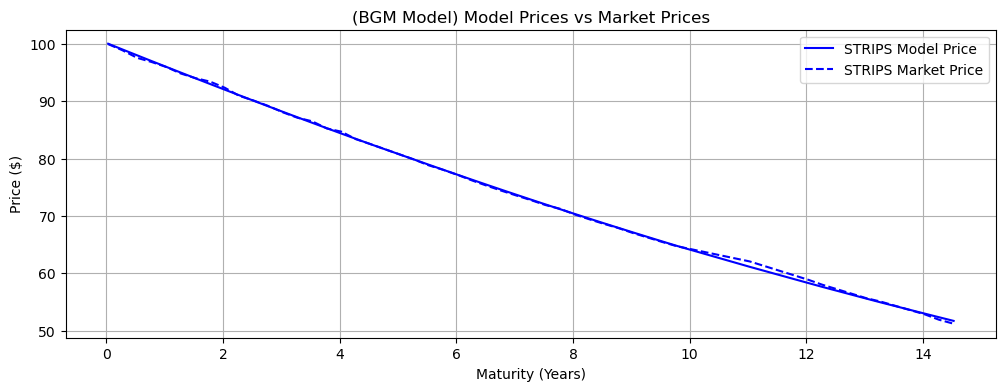

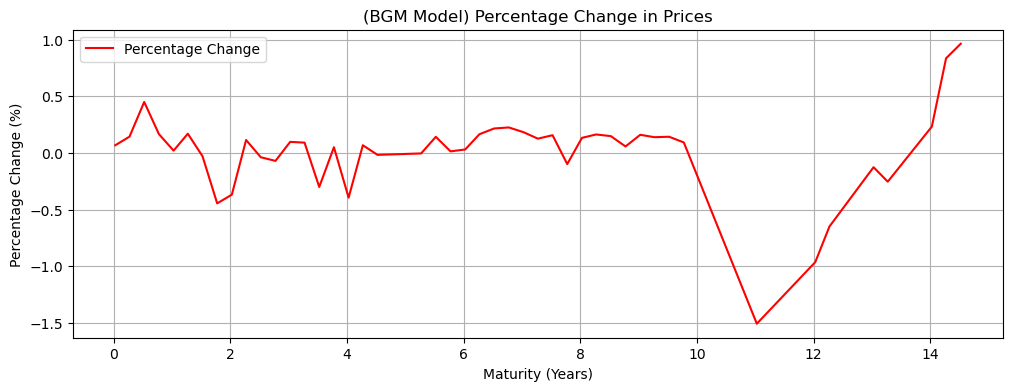

In [15]:
# Calculate percentage change in prices
percentage_change = ((zero_coupon_prices - strips_prices) / strips_prices) * 100

# Plot original graph
plt.figure(figsize=(12, 4))
plt.plot(maturities, zero_coupon_prices, 'b-', label='STRIPS Model Price', linewidth=1.5)
plt.plot(maturities, strips_prices, 'b--', label='STRIPS Market Price', linewidth=1.5)
plt.xlabel('Maturity (Years)')
plt.ylabel('Price ($)')
plt.title('(BGM Model) Model Prices vs Market Prices')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot percentage change graph
plt.figure(figsize=(12, 4))
plt.plot(maturities, percentage_change, 'r-', label='Percentage Change', linewidth=1.5)
plt.xlabel('Maturity (Years)')
plt.ylabel('Percentage Change (%)')
plt.title('(BGM Model) Percentage Change in Prices')
plt.legend()
plt.grid(True)
plt.show()


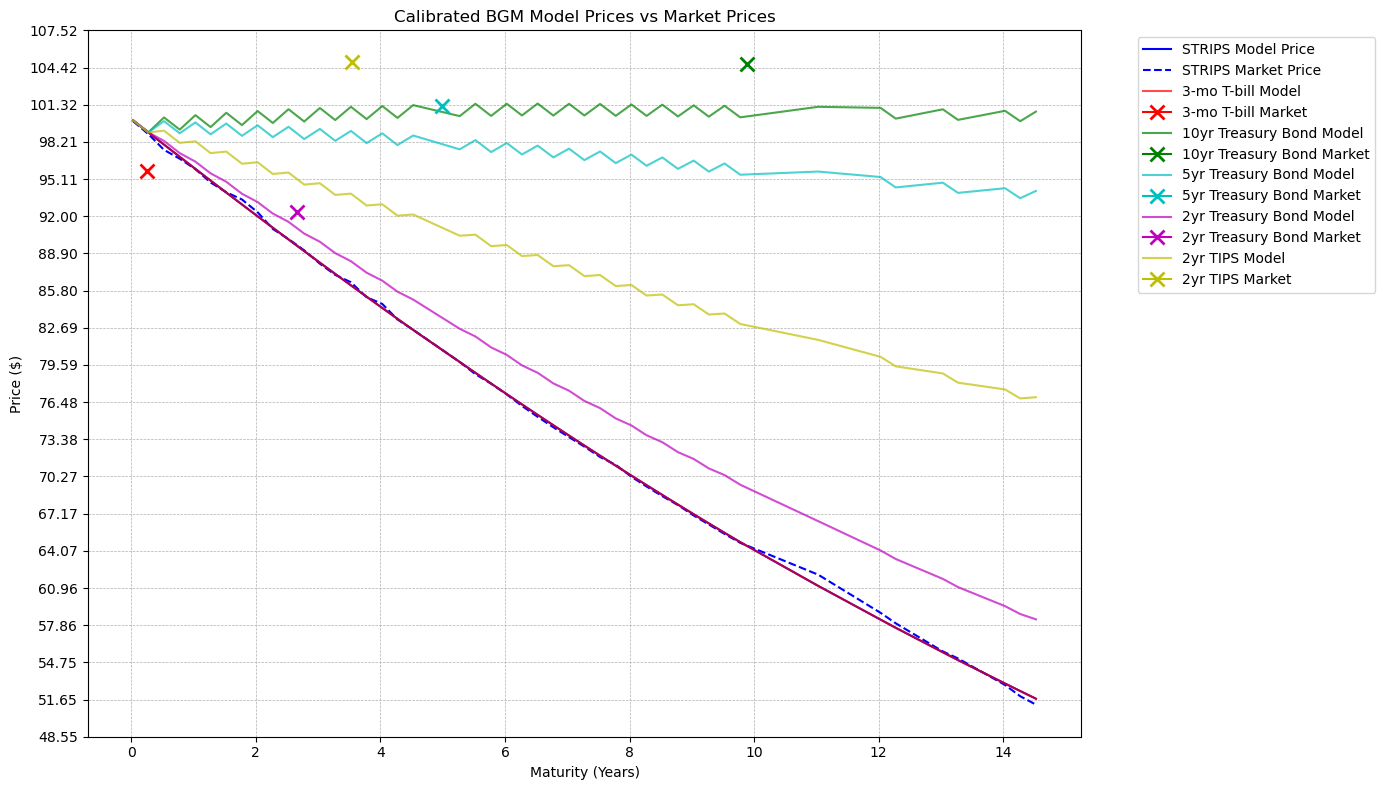

In [8]:
# All Bonds
plt.figure(figsize=(14, 8))

# STRIPS
plt.plot(maturities, zero_coupon_prices, 'b-', label='STRIPS Model Price', linewidth=1.5)
plt.plot(maturities, strips_prices, 'b--', label='STRIPS Market Price', linewidth=1.5)

# Bonds
colors = ['r', 'g', 'c', 'm', 'y', 'k', 'orange', 'purple']
for i, (security, prices) in enumerate(bond_model_prices.items()):
    if i > 4:
        break
    plt.plot(maturities, prices, color=colors[i], linestyle='-', label=f'{security} Model', alpha=0.7)
    maturity = bond_data.loc[bond_data['Security'] == security, 'Maturity'].values[0]
    market_price = bond_data.loc[bond_data['Security'] == security, 'Price'].values[0]
    plt.plot(maturity, market_price, marker='x', color=colors[i], markersize=10, markeredgewidth=2, label=f'{security} Market')

plt.xlabel('Maturity (Years)')
plt.ylabel('Price ($)')
plt.title('Calibrated BGM Model Prices vs Market Prices')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add tighter grid with more lines
y_min, y_max = plt.ylim()
plt.yticks(np.linspace(y_min, y_max, 20))  # Increase the number of ticks on the y-axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

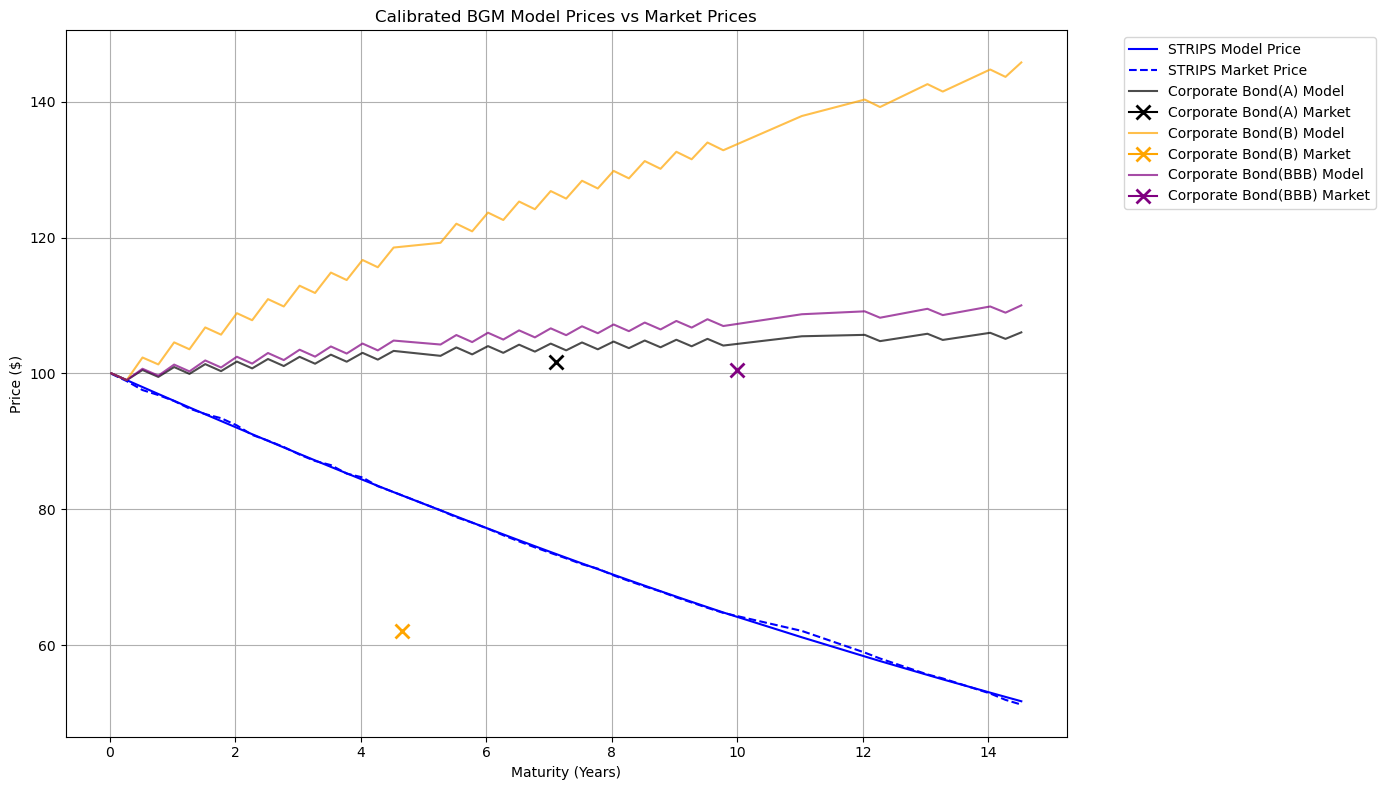

In [9]:

# All Bonds
plt.figure(figsize=(14, 8))

# STRIPS
plt.plot(maturities, zero_coupon_prices, 'b-', label='STRIPS Model Price', linewidth=1.5)
plt.plot(maturities, strips_prices, 'b--', label='STRIPS Market Price', linewidth=1.5)

# Bonds
colors = ['r', 'g', 'c', 'm', 'y', 'k', 'orange', 'purple']
for i, (security, prices) in enumerate(bond_model_prices.items()):
    if i >= 5:
        plt.plot(maturities, prices, color=colors[i], linestyle='-', label=f'{security} Model', alpha=0.7)
        maturity = bond_data.loc[bond_data['Security'] == security, 'Maturity'].values[0]
        market_price = bond_data.loc[bond_data['Security'] == security, 'Price'].values[0]
        plt.plot(maturity, market_price, marker='x', color=colors[i], markersize=10, markeredgewidth=2, label=f'{security} Market')

plt.xlabel('Maturity (Years)')
plt.ylabel('Price ($)')
plt.title('Calibrated BGM Model Prices vs Market Prices')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()